<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) deep network,
(2) cost function, (3) method of calculating accuracy,
(4) an image that shows the dense prediction produced by your network on the pos_test_000072.png image.
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 40% Proper implementation of a loss function and train/test set accuracy measure
* 10% Tidy visualizations of loss of your dense predictor during training
* 10% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

**DONE:**
* Watch tutorial

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

**TODO:**

**DONE:**
* Create a Network that classifies each pixel as a 1 or 0 for cancerous / not cancerous

___

### Part 1a
Implement your network topology


Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

**DONE:**
* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties


___
The intention of this lab is to learn how to make deep neural nets and implement loss function.
Therefore we'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"
import traceback

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
root = "dataset"
dataset = CancerDataset(root)

0it [00:00, ?it/s]

100%|█████████▉| 2749169664/2750494655 [02:40<00:00, 16852607.72it/s]

Extracting dataset/cancer_data.tar.gz


2750496768it [02:50, 16852607.72it/s]                                

Untarring dataset/cancer_data.tar


torch.Size([3, 512, 512])


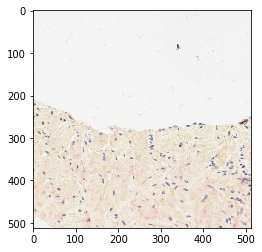

In [ ]:
# print(dataset[0][0].size())
# img = np.transpose(dataset[0][0], (1,2,0))
# print(img.size())
# plt.imshow(img)
# plt.show()  
print(dataset[0][0].size())
plt.imshow(dataset[173][0].numpy().T)
plt.show()
# for i in range(100):
#     if (dataset[i][1].numpy().sum() != 0):
#         print(dataset[i][1].numpy().sum(), i)
#         plt.imshow(dataset[i][1].numpy().T)
#         plt.show()

___

### Part 1b
Implement a cost function

You should still use cross-entropy as your cost function, but you may need to think hard about how exactly to set this up – your network should output cancer/not-cancer probabilities for each pixel, which can be viewed as a two-class classification problem.

**TODO:**



**DONE:** (Not Required for this Lab)

* Adapt CrossEntropyLoss for 2 class pixel classification

In [ ]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer


In [ ]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

# TODO: You need to change this to fit the UNet structure!!!
class CancerDetection(nn.Module):
    def __init__(self, dataset):
        super(CancerDetection, self).__init__()
        
        self.dataset = dataset
        
        STAMP_DEPTH = 32
        
        # Downwards direction set up
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.down_block1 = ConvBlock(in_channels=3, out_channels=STAMP_DEPTH)
        self.down_block2 = ConvBlock(in_channels=STAMP_DEPTH, out_channels=STAMP_DEPTH*2)
        self.down_block3 = ConvBlock(in_channels=STAMP_DEPTH*2, out_channels=STAMP_DEPTH*4)
        self.down_block4 = ConvBlock(in_channels=STAMP_DEPTH*4, out_channels=STAMP_DEPTH*8)
        
        self.mid_block = ConvBlock(in_channels=STAMP_DEPTH*8, out_channels=STAMP_DEPTH*16)
        
        # Upwards direction set up
        self.conv_transp1 = nn.ConvTranspose2d(in_channels=STAMP_DEPTH*16
                                           ,out_channels=STAMP_DEPTH*8
                                           ,kernel_size=2, stride=2)
        self.up_block1     = ConvBlock(STAMP_DEPTH * 16, STAMP_DEPTH * 8)
        self.conv_transp2      = nn.ConvTranspose2d(in_channels=STAMP_DEPTH * 8
                                                    , out_channels=STAMP_DEPTH * 4
                                                    , kernel_size=2, stride=2)
        self.up_block2     = ConvBlock(STAMP_DEPTH * 8, STAMP_DEPTH * 4)
        self.conv_transp3      = nn.ConvTranspose2d(in_channels=STAMP_DEPTH * 4
                                                    , out_channels=STAMP_DEPTH * 2
                                                    , kernel_size=2, stride=2)
        self.up_block3     = ConvBlock(STAMP_DEPTH * 4, STAMP_DEPTH * 2)
        self.conv_transp4  = nn.ConvTranspose2d(in_channels=STAMP_DEPTH*2
                                                , out_channels=STAMP_DEPTH
                                                , kernel_size=2, stride=2)
        self.up_block4     = ConvBlock(STAMP_DEPTH * 2, STAMP_DEPTH)
        
        # Conv 1x1
        self.final_conv    = nn.Conv2d(in_channels=STAMP_DEPTH
                                       , out_channels=2, kernel_size=1)
 
    def forward(self, input):
        # Downwards direction
        o1 = self.down_block1(input)#;# print("Down Conv o1", o1.size())
        o2 = self.max_pool(o1);# print("Pool o2", o2.size())
        o3 = self.down_block2(o2);# print("Down Conv o3", o3.size())
        o4 = self.max_pool(o3);# print("Pool o4", o4.size())
        o5 = self.down_block3(o4);# print("Down Conv o5", o5.size())
        o6 = self.max_pool(o5);# print("Pool o6", o6.size())
        o7 = self.down_block4(o6);# print("Down Conv o7", o7.size())
        o8 = self.max_pool(o7);# print("Pool o8", o8.size())
        
        # Level block
        o9 = self.mid_block(o8);# print("Mid o9", o9.size())
        
        # Upwards direction
        o10 = self.conv_transp1(o9);# print("Conv Transpose o10", o10.size())
        cat1 = torch.cat((o7, o10), 1);# print("Cat1", cat1.size())
        o11 = self.up_block1(cat1);# print("Up Block o11", o11.size())
        o12 = self.conv_transp2(o11);# print("Conv Transpose o12", o12.size())
        cat2 = torch.cat((o5, o12), 1);# print("Cat2", cat2.size())
        o13 = self.up_block2(cat2);# print("Up Block o13", o13.size())
        o14 = self.conv_transp3(o13);# print("Conv Transpose o14", o14.size())
        cat3 = torch.cat((o3, o14), 1);# print("Cat3", cat3.size())
        o15 = self.up_block3(cat3);# print("Up Block o15", o15.size())
        o16 = self.conv_transp4(o15);# print("Conv Transpose o16", o16.size())
        cat4 = torch.cat((o1, o16), 1);# print("Cat4", cat4.size())
        o17 = self.up_block4(cat4);# print("Up Block 017", o17.size())
        
        # Final Conv
        o18 = self.final_conv(o17)
        
        return o18
    
    def __len__():
        return len(self.dataset)


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
    
    
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size = 3, stride = 1, padding = 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(out_channels,out_channels,kernel_size = 3, stride = 1, padding = 1)
        self.relu4 = nn.ReLU()
    
        self.sequence = nn.Sequential(self.conv1, self.relu2, self.conv3, self.relu4)
 
    def forward(self, input):
        return self.sequence(input)

In [ ]:
def get_accuracy(y_hat, y_truth):
    ps = torch.exp(y_hat)
    equality = (y_truth == ps.max(dim=1)[1].float())
    return (equality.type(torch.FloatTensor).mean())

In [ ]:
# Create your datasets and neural network as you have before
# torch.cat((output1, output2))


In [ ]:
# This is what was talked about in the video for memory management
losses = []
val_losses = []
accuracies = []
img_72_prediction = None

def scope():
    try:
        #your code for calling dataset and dataloader
        # Instantiate the train and validation sets
        train_dataset = CancerDataset(root="dataset", download=False, size=128, train=True)
       
        # validation dataset
        val_dataset = CancerDataset(root="dataset", download=False, size=128, train=False)

        # Instantiate your data loaders
        train_loader = DataLoader(train_dataset,
                                 batch_size=8, 
                                 pin_memory=True, shuffle=True) # write batch to same block of mem. in GPU every time (speed improvement)

        val_loader = DataLoader(val_dataset,
                                 batch_size=8, 
                                 pin_memory=True, shuffle=True) # write batch to same block of mem. in GPU every time (speed improvement)

        model = CancerDetection(train_dataset)
        model = model.cuda()

        gc.collect()
        print(torch.cuda.memory_allocated(0) / 1e9) 

        # Initialize Objective and Optimizer and other parameters
        objective = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Run your training and validation loop and collect stats
        num_epochs = 25

        # get a loading bar
        loop = tqdm(total=len(train_loader) * num_epochs, position=0)

        for epoch in range(num_epochs):

            for batch, (x, y_truth) in enumerate(train_loader):
                # move data to GPU
                x, y_truth = x.cuda(async=True).float(), y_truth.cuda(async=True).float() # does not call "sync() at end of function"
                # Train Orthogonal Initialized Parameter Model
                y_hat = model(x)
                
                accuracies.append(get_accuracy(y_hat, y_truth))
                loss = objective(y_hat, y_truth.long()) # P.S. 'objective' is a class, NOT a function
                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # update loading bar
                loop.set_description(f'loss:{losses[-1]}')
                loop.update(1) 

            val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x, y in val_loader])
            val_losses.append((len(losses), val))

        loop.close()
        
        model.eval()
        
        global img_72_prediction
        
        test_72_image = val_dataset[172][0].unsqueeze(0).cuda()
        img_72_prediction = model(test_72_image)

    except:
        traceback.print_exc()
    
scope()


  0%|          | 0/4200 [00:00<?, ?it/s]

0.031568896


loss:0.039217591285705566: 100%|██████████| 4200/4200 [39:26<00:00,  2.04it/s]



___

### Part 2

Plot performance over time

Please generate a plot that shows loss on the training set as a function of training time. Make sure your axes are labeled!

**TODO:**

**DONE:**

* Plot training loss as function of training time (not Epochs)


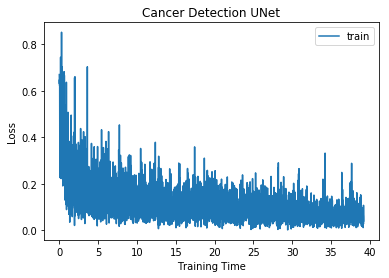

In [ ]:
# Your plotting code here
times = np.linspace(0, 39.2, len(losses))
plt.figure(0)
plt.plot(times, losses, label="train")
plt.xlabel("Training Time")
plt.ylabel("Loss")
plt.legend()
plt.title("Cancer Detection UNet")
plt.show()

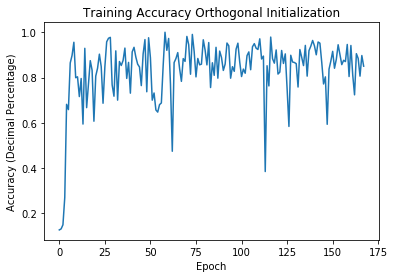

In [ ]:
# Plot accuracy
plt.figure(1)
iteration = np.arange(len(accuracies))
plt.plot(iteration, accuracies)
plt.title("Training Accuracy Over Time")
plt.xlabel("Time")
plt.ylabel("Accuracy (Decimal Percentage)")
plt.show()

___

### Part 3

Generate a prediction on the pos_test_000072.png image

Calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

**TODO:**

**DONE:**

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

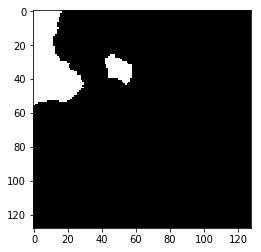

In [ ]:
# Code for testing prediction on an image
prediction_img = np.argmax(img_72_prediction.squeeze(0).cpu().detach().numpy(), axis=0)
plt.imshow(~prediction_img, cmap='Greys')
plt.show()